In [5]:
%matplotlib inline
from collections import defaultdict
import pymc as pm
from pymc.Matplot import plot
import numpy as np
from matplotlib import pyplot as plt
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId
import jsonpickle
from scipy.stats import loggamma

In [6]:
import sys
sys.path.insert(0,'../Peergrade/peergrade/')
from application.model import data_model


### Normal

In [ ]:
data = list()
for i in range(0,1000):
    data.append(np.random.lognormal(mean=0,sigma=1/1000.0))
plt.hist(data, bins=25, histtype="stepfilled", normed=True)

In [ ]:
B_mu = pm.Normal('B_mu_generator',0,1000)
data = list()
for i in range(0,1000):
    data.append(B_mu.random())
plt.hist(data, bins=25, histtype="stepfilled", normed=True)

In [ ]:
pm.skew_normal_like([0.2,0.6,0.5],0.5,100,1)

In [ ]:
B_mu = pm.Normal('B_mu_generator',0,500)
data = list()
for i in range(0,1000):
    data.append(B_mu.random())
plt.hist(data, bins=25, histtype="stepfilled", normed=True)

### Beta

In [ ]:
B_tau = pm.Beta('B_tau_generator',2,1.5)
data = list()
for i in range(0,1000):
    data.append(B_tau.random())
plt.hist(data, bins=25, histtype="stepfilled", normed=True)

### Gamma

In [ ]:
loggamma.rvs(50,scale=1/0.1)

In [ ]:
data = list()
for i in range(0,1000):
    data.append(loggamma.rvs(50,scale=1/0.1))
plt.hist(data, bins=25, histtype="stepfilled", normed=True)

In [ ]:
B_tau = pm.Gamma('B_tau_generator',50,0.1)
data = list()
for i in range(0,1000):
    data.append(B_tau.random())
plt.hist(data, bins=25, histtype="stepfilled", normed=True)

In [ ]:
B_tau = pm.Gamma('B_tau_generator',50,0.1)
data = list()
for i in range(0,1000):
    B_val = B_tau.random()
    B = pm.Normal('B_generator',0,B_val)
    data.append(B.random())
plt.hist(data, bins=25, histtype="stepfilled", normed=True)

In [ ]:
B_tau = pm.Gamma('B_tau_generator',50,0.1)
B = pm.Normal('B_generator',0,B_tau)
data = list()
for i in range(0,1000):
    data.append(B.random())
plt.hist(data, bins=25, histtype="stepfilled", normed=True)

In [ ]:
B = pm.Normal('B_generator',0,500)
data = list()
for i in range(0,1000):
    B_val = B_tau.random()
    B = pm.Normal('B_generator',0,B_val)
    data.append(B.random())
plt.hist(data, bins=25, histtype="stepfilled", normed=True)

### NormalGamma

In [ ]:
B_tau = pm.Gamma('B_tau_generator',50,0.1)
data_mu = list()
data_tau = list()
for i in range(0,1000):
    b_tau = B_tau.random()
    
    data_tau.append(b_tau)
    B_mu = pm.Normal('B_mu_generator',0, 1*b_tau)
    data_mu.append(B_mu.random())
plt.subplot(211)
plt.title('Mu')
plt.hist(data_mu, bins=25, histtype="stepfilled", normed=True)
plt.subplot(212)
plt.title('Tau')
plt.hist(data_tau, bins=25, histtype="stepfilled", normed=True)
print 1/np.var(data_mu)

# Reformating data and seralizing

In [ ]:
class Question(object):
    def __init__(self,_id,_type, assignment, text, max_grade_value):
        self._id = _id
        self._type = _type
        self.assignment = assignment
        self.text = text
        self.max_grade_value = max_grade_value

In [ ]:
class Answer(object):
    def __init__(self, _id, grading, question, flagged):
        self._id = _id
        self.grading = grading
        self.question = question
        self.flagged = flagged
        
    def add_text_answere(self, text):
        self.text = text
    def add_value_answere(self, graded_value, normalized):
        self.grade_value = graded_value
        self.normalized = normalized

In [ ]:
class Grading(object):
    def __init__(self, _id, grader, handin, answeres, assignment, feedback_grade):
        self._id = _id
        self.grader = grader
        self.answeres = answeres # list of asnwer ids
        self.handin = handin
        self.assignment = assignment
        self.feedback_grade = feedback_grade

In [ ]:
class User(object):
    def __init__(self, _id, name, graded_handins):
        self._id = _id
        self.name = name
        self.graded_handins = graded_handins # list of handins ids

In [ ]:
class Handin(object):
    def __init__(self,_id, assignment, owners, gradings):
        self._id = _id
        self.assignment = assignment
        self.owners = owners # list of grader ids
        self.gradings = gradings #list of grading ids

In [ ]:
class Assignment(object):
    def __init__(self, _id, title, questions, handins):
        self._id = _id
        self.title = title
        self.questions = questions # list of question ids
        self.handins = handins # list of handins ids

In [ ]:
class Course(object):
    def __init__(self, _id, title, assignments, participants):
        self._id = _id
        self.title = title
        self.assignments = assignments # list of assignments ids
        self.participants = participants # list of graders ids

## Fetching data

In [ ]:
client = MongoClient()
db = client.heroku_rnwkcq9r

Find all the ids of the relevant objects

In [ ]:
assignments_i = list()
graders_i = list()
questions_i = list() # assignment id as key
assignment_question_i = defaultdict(list)
questions_assignment_i = dict() # assignment id as key
handins_i = defaultdict(list) # assignment id as key
gradings_i = defaultdict(list) # handin id as key 
grading_handin_i = dict() # grading id as key
answeres_i = defaultdict(list) # gradings id as key

course = db.course.find_one({'_id': ObjectId("55d9cb9ea6fb8f00080da4a1")})

for gradr_i in course['students']:
    for g_d in db.user.find({'_id': gradr_i}):
        graders_i.append(g_d)

for ass_d in db.assignment.find({'course': course['_id']}):
    ass_i = str(ass_d['_id'])
    assignments_i.append(ass_d)
    # questions 
    for sec_i in ass_d['sections']:
        sec_d = db.question_section.find_one({'_id': sec_i})
        for q_i in sec_d['questions']:
            for q_d in db.question.find({'_id': q_i}):
                questions_i.append(q_d)
                questions_assignment_i[str(q_i)] = ass_i
                assignment_question_i[str(ass_i)].append(str(q_i))
                
    # handins
    for han_d in db.handin.find({'assignment': ObjectId(ass_i)}):
        han_i = str(han_d['_id'])
        handins_i[ass_i].append(han_d)
        #gradings
        for grad_d in db.report_grade.find({'handin': ObjectId(han_i), 'state': 'ANSWERED'}):
            grad_i = str(grad_d['_id'])
            gradings_i[han_i].append(grad_d)
            grading_handin_i[grad_i] = han_i
            #answeres
            for answer_d in db.answer.find({'report_grade': ObjectId(grad_i)}):
                answeres_i[grad_i].append(answer_d)

Use the found ids to populate the previous defined objects

In [ ]:
def attr(entries,key):
    return map(lambda x: x[key],entries)

In [ ]:
def question_max_value(question_id):
    question = db.question.find_one({'_id': ObjectId(question_id)})
    if question['question_type'] == "boolean":
        return 1
    elif question["question_type"] == "numerical":
        if 'numericalAnswers' in question:
            max_value = max(map(int,question['numericalAnswers'].keys()))
            return max_value
        else:
            return 5

In [ ]:
def answer_value_normalized(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    q_id = answer['question']
    if 'numerical_answer' in answer:
        return answer['numerical_answer'] / float(question_max_value(q_id))
    elif 'boolean_answer' in answer:
        return answer['boolean_answer'] / float(question_max_value(q_id))

In [ ]:
def answer_value(answer_id):
    '''returns the normalized value of an answere'''
    answer = db.answer.find_one({'_id': answer_id})
    q_id = answer['question']
    if 'numerical_answer' in answer:
        return answer['numerical_answer']
    elif 'boolean_answer' in answer:
        return answer['boolean_answer']

In [ ]:
def graders_gradings(grader_id):
    gradings = list()
    for g in db.report_grade.find({'giver': grader_id}):
        gradings.append(g)
    return gradings

Question objects: dependent on assignment

In [ ]:
with open(r"BigDataFormattedData/questions.txt", "w") as o_file:
    for q in questions_i:
        _id = str(q['_id'])
        q_obj = Question(_id,q['question_type'],questions_assignment_i[_id],q['text'],question_max_value(_id))
        q_enc = jsonpickle.encode(q_obj,unpicklable=False)
        o_file.write(q_enc + "\n")

Answer objects: dependent on question

In [ ]:
with open(r"BigDataFormattedData/answers.txt", "w") as o_file:
    for g, ans in answeres_i.iteritems():
        for a in ans:
            _id = a['_id']
            flagged = False
            if 'flagged' in a:
                flagged = a['flagged'] 
            a_obj = Answer(str(_id), g, str(a['question']),flagged)
            if 'text_answer'in a:
                a_obj.add_text_answere(a['text_answer'])
            else:
                a_obj.add_value_answere(answer_value(_id),answer_value_normalized(_id))
            a_enc = jsonpickle.encode(a_obj,unpicklable=False)
            o_file.write(a_enc + "\n")

Grading objects: dependant on grader, answeres and handin

In [ ]:
with open(r"BigDataFormattedData/gradings.txt", "w") as o_file:
    for h, gradings in gradings_i.iteritems():
        for g in gradings:
            _id = str(g['_id'])
            answeres = map(lambda x:str(x),attr(answeres_i[_id],'_id'))
            feedback = None
            if 'feedback_grade' in g:
                feedback = g['feedback_grade']
            g_obj = Grading(_id, str(g['giver']), str(g['handin']), answeres, str(g['assignment']),feedback)
            g_enc = jsonpickle.encode(g_obj,unpicklable=False)
            o_file.write(g_enc + "\n")

Grader object: dependent on handins

In [ ]:
with open(r"BigDataFormattedData/users.txt", "w") as o_file:
        for g in graders_i:
            _id = str(g['_id'])
            g_obj = User(_id, g['name'],map(str,(attr(graders_gradings(g['_id']),'_id'))))
            g_enc = jsonpickle.encode(g_obj,unpicklable=False)
            o_file.write(g_enc + "\n")

Handin objects: dependent on graders and gradings

In [ ]:
with open(r"BigDataFormattedData/handins.txt", "w") as o_file:
    for a, handins in handins_i.iteritems():
        for h in handins:
            _id = str(h['_id'])
            owners = map(lambda x:str(x),h['students'])
            gradings = map(lambda x:str(x),attr(gradings_i[_id],'_id'))
            h_obj = Handin(_id, a, owners, gradings)
            h_enc = jsonpickle.encode(h_obj,unpicklable=False)
            o_file.write(h_enc + "\n")

Assignment objects: depndent on questions and handins

In [ ]:
with open(r"BigDataFormattedData/assignments.txt", "w") as o_file:
    for a in assignments_i:
        _id = str(a['_id'])
        a_obj = Assignment(_id, a['title'], assignment_question_i[_id], map(str,attr(handins_i[_id],'_id')))
        a_enc = jsonpickle.encode(a_obj,unpicklable=False)
        o_file.write(a_enc + "\n")

Course object: dependent on graders and assignemnt

In [ ]:
with open(r"BigDataFormattedData/courses.txt", "w") as o_file:
    _id = str(course['_id'])
    assignments = map(str,attr(assignments_i,'_id'))
    c_obj = Course(_id, course['title'], assignments, map(str,course['students']))
    c_enc = jsonpickle.encode(c_obj,unpicklable=False)
    o_file.write(c_enc + "\n")

## Storing data

In [ ]:
client = MongoClient()
db = client.heroku_rnwkcq9r

In [ ]:
# finds the reported score for each handins in an assignment
# returns a list containing the score of each handin
def course_handins_id(course_id):
    handins_reports = list()
    assignments = db.assignment.find({'course': course_id})
    for assignment in assignments:
        
        handins = db.handin.find({'assignment': assignment['_id']})
        for handin in handins:
            handins_reports.append(handin['_id'])
    return handins_reports

In [ ]:
len(course_handins_id(ObjectId("55d9cb9ea6fb8f00080da4a1")))

In [ ]:
from math import *
from matplotlib.pylab import * 


n=10000
rho=.99 #correlation
#Means
m1 = 10
m2 = 20
#Standard deviations
s1 = 1
s2 = 1
#Initialize vectors
x=zeros(n, float)
y=zeros(n, float)
sd=sqrt(1-rho**2)
# the core of the method: sample recursively from two normal distributions
# The mean for the current sample, is updated at each step.
for i in range(1,n):
  x[i] = normal(m1+rho*(y[i-1]-m2)/s2,s1*sd)
  y[i] = normal(m2+rho*(x[i-1]-m1)/s1,s2*sd)

scatter(x,y,marker='d',c='r')
xlabel('x')
ylabel('y')
grid()

show()

In [2]:
def norm_log_pdf(x,u,t):
    return -0.5*t*(x-u)**2+np.log(t)-np.log(np.sqrt(2.0*math.pi))

def gamma_log_pdf(x,a,b):
    return a*np.log(b)-np.log(math.gamma(a))+(a-1.0)*np.log(x)-b*x

def norm_gamma_log_pdf(u,t,ga,la,a,b):
    return a*np.log(b)+np.log(np.sqrt(la))-np.log(math.gamma(a))-np.log(np.sqrt(2.0*math.pi))+(a-1)*np.log(t)-np.log(b*t)-0.5*t*la*(u-ga)**2

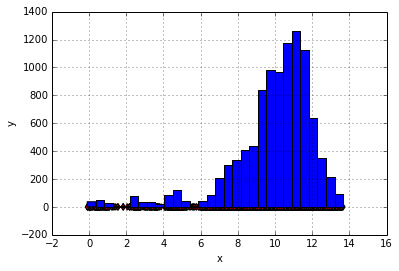

In [19]:
from math import *
from matplotlib.pylab import * 


n=10000

#Means
m1 = 10.0
#Standard deviations
s1 = 0.5
#Initialize vectors
x=zeros(n, float)
y=zeros(n, float)
x[0] = 0.0
log_x = norm_log_pdf(0,m1,s1)
# the core of the method: sample recursively from two normal distributions
# The mean for the current sample, is updated at each step.
i = 1
while i < n:
    # Sample u_h and t_h
  
    # Propose new candidates
    x_c = np.random.normal(x[i-1],0.1)
    #draw from gamma
    p_ = norm_log_pdf(x_c,m1,s1)
    alpha = min(1.0,p_-log_x)
    if np.log(np.random.random()) <= alpha:
        x[i] = x_c
        log_x = p_
        i = i + 1

plt.hist(x,bins=30)
scatter(x,y,marker='d',c='r')
xlabel('x')
ylabel('y')
grid()

show()

In [61]:
s_0 = np.array([1,0])
T = np.matrix('0.9,0.1;0.5,0.5')
s_0, T

(array([1, 0]), matrix([[ 0.9,  0.1],
         [ 0.5,  0.5]]))

In [62]:
s_1 = np.dot(s_0,T)
s_1

matrix([[ 0.9,  0.1]])

In [63]:
s_2 = np.dot(s_1,T)
s_2

matrix([[ 0.86,  0.14]])

In [64]:
s_2 = np.dot(s_0,T**2)
s_2

matrix([[ 0.86,  0.14]])

In [ ]:
from numpy import *
import matplotlib.pylab as pl

def gibbs_sampler(alpha,delta,gamma,y,t):
    #initialize beta
    beta=1

    num_iter=1000

    beta_draws=[]
    lambda_draws=[]

    for i in range(num_iter):
        #sample lambda given other lambdas and beta
        lambdas=lambda_update(alpha,beta,y,t)

        #record sample
        lambda_draws.append(lambdas)

        #sample beta given lambda samples
        beta=beta_update(alpha,gamma,delta,lambdas,y)

        #record sample
        beta_draws.append(beta)

    pl.plot(beta_draws)
    pl.show()

def lambda_update(alpha,beta,y,t):

    new_alpha=[(x+alpha) for x in y]
    new_beta=[1.0/(a+beta) for a in t]#Changed here

    #sample from this distribution 10 times
    samples=random.gamma(new_alpha,new_beta)
    return samples


def beta_update(alpha,gamma,delta,lambdas,y):
    #get sample
    sample=random.gi(len(y)*alpha+gamma, 
                        1.0 / (delta+sum(lambdas)))#Changed here
    return sample

y=[5,1,5,14,3,19,1,1,4,22]
t=[94,16,63,126,5,31,1,1,2,10]

alpha=1.8
gamma=0.01
delta=1

gibbs_sampler(alpha,delta,gamma,y,t)

In [7]:
count = 0
questions = list()
grade_p_s = list()
grade_p_h = list()
students = list()
handins = list()

assignments_d = data_model.Assignment.objects()
for assignment in assignments_d:
    v = len(data_model.Handin.objects(assignment=assignment))
    if v != 0:
        handins.append(v)
    v = len(assignment.course.students)
    if v != 0:
        students.append(len(assignment.course.students))
    if assignment.grades_per_student != 0:
        grade_p_s.append(assignment.grades_per_student)
    if assignment.grades_per_handin != 23:
        grade_p_h.append(assignment.grades_per_handin)
    n_questions = 0
    for section in assignment.sections:
        for question in section.questions:
            if question.question_type == "text":
                n_questions = n_questions + 1
    questions.append(n_questions)
    count = count + 1

In [8]:
print "Questions"
print "Mean: %f Median: %f Max: %i Min: %i" % (np.mean(questions), np.median(questions), max(questions), min(questions))
print "Students"
print "Mean: %f Median: %f Max: %i Min: %i" % (np.mean(students), np.median(students), max(students), min(students))
print "Hand-ins"
print "Mean: %f Median: %f Max: %i Min: %i" % (np.mean(handins), np.median(handins), max(handins), min(handins))
print "Grades per student"
print "Mean: %f Median: %f Max: %i Min: %i" % (np.mean(grade_p_s), np.median(grade_p_s), max(grade_p_s), min(grade_p_s))
print "Grades per handin"
print "Mean: %f Median: %f Max: %i Min: %i" % (np.mean(grade_p_h), np.median(grade_p_h), max(grade_p_h), min(grade_p_h))

Questions
Mean: 2.505348 Median: 2.000000 Max: 22 Min: 0
Students
Mean: 54.801802 Median: 22.000000 Max: 322 Min: 1
Hand-ins
Mean: 18.335505 Median: 9.000000 Max: 253 Min: 1
Grades per student
Mean: 2.716714 Median: 3.000000 Max: 6 Min: 1
Grades per handin
Mean: 4.005362 Median: 4.000000 Max: 11 Min: 1


In [9]:
grade_p_h

[3,
 8,
 3,
 2,
 3,
 3,
 4,
 3,
 4,
 4,
 3,
 11,
 6,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,

(array([ 236.,   57.,   22.,   21.,    8.,    0.,    6.,   14.,    1.,    9.]),
 array([   0. ,   32.2,   64.4,   96.6,  128.8,  161. ,  193.2,  225.4,
         257.6,  289.8,  322. ]),
 <a list of 10 Patch objects>)

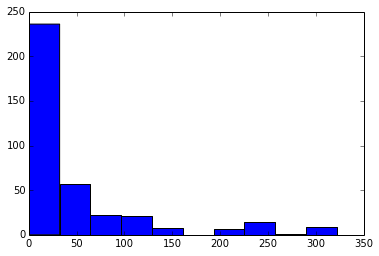

In [19]:
plt.hist(students)